In [1]:
import sys
import os
import time

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
#from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D,NVSolver2D,torch_NVSolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Random Field Generator

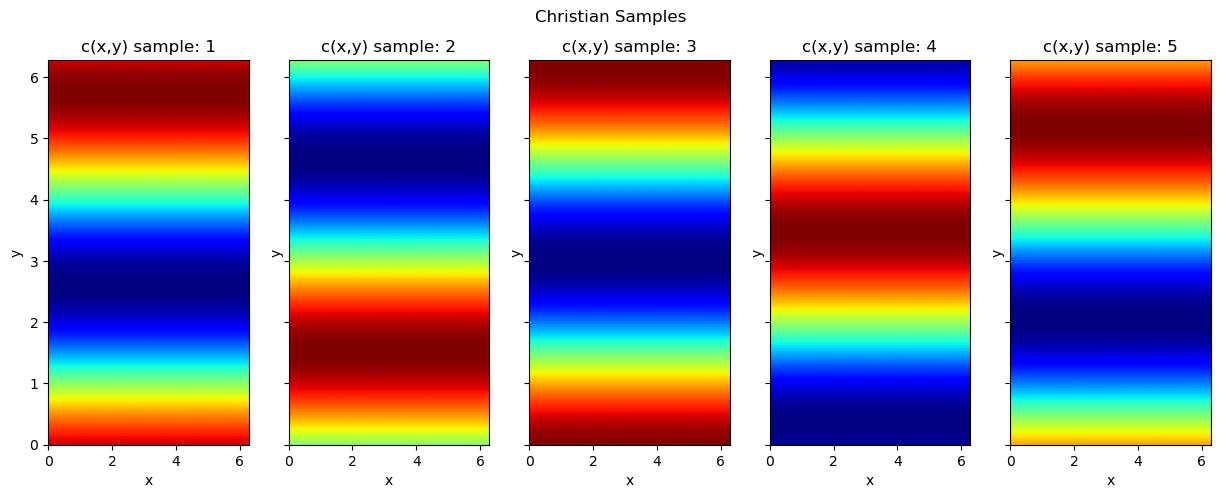

In [13]:
X = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 100  # Number of samples you want to generate
seed = 108  # Base seed for reproducibility
N_KL = 1

rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,n_samples))

# Generate n samples of omega0
omega0_ = omega0_samples(X, Y, theta, d = 5,tau=np.sqrt(2))

_, axs = plt.subplots(1,5,figsize = (15,5),  sharey=True)
plt.suptitle("Christian Samples")
for i in range(5):
    c = omega0_[:,:,i]

    axs[i].pcolormesh(X, Y, c, shading="gouraud", cmap = "jet")
    axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")


# FEM Approach

In [14]:
def forcing_function(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=100, dt=0.01, T=10.0, nu=1e-4, force_func=None, d= 5, tau =10,seed = 108)

fem_solver.run()

Text(0, 0.5, 'y')

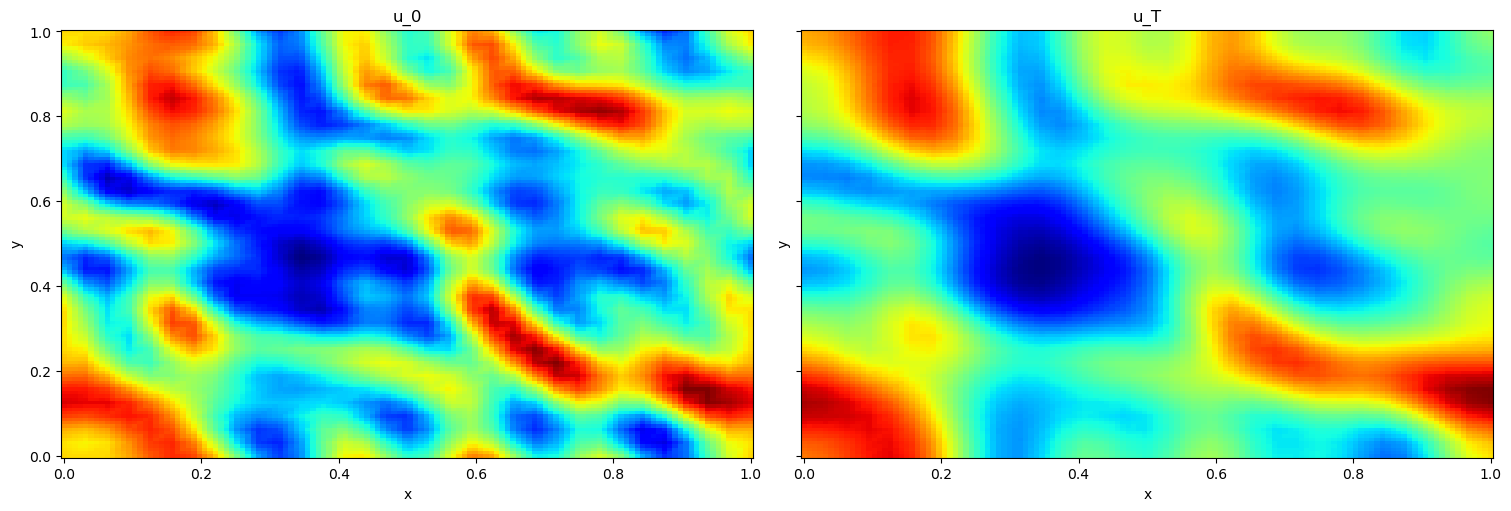

In [15]:
N = 128
xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_values =  fem_solver.evaluate_at_points(points)

fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained', sharey=True)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),
                   (X, Y), method='cubic')


z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),
                   (X, Y), method='cubic')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0].pcolormesh(X, Y, z_0, cmap='jet')
axs[0].set_title("u_0")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1].pcolormesh(X, Y, z_pred, cmap='jet')
axs[1].set_title("u_T")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Pseudo Spectral Method

In [16]:
def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))
def torch_force_function(X, Y):
    return  (torch.sin(X + Y) + torch.cos(X + Y))
torch.set_default_dtype(torch.float64)


solver = VorticitySolver2D(N=128, L=2*np.pi, T=2.0, nu=1e-2, dt=5e-4,num_sol=100, method='CN',force = force_function)
solver2 = torch_NVSolver2D(N=128, L=2*torch.pi, T=2.0, nu=1e-2, dt=5e-4,num_sol=100, method='CN',force = torch_force_function, device=device)

start_time = time.time()
results1 = solver.run_simulation(np.array(omega0_[:,:,0]))
solver_time = time.time() - start_time  # Time taken for loss computation
print(f"Time Solver 1 sample 1: {solver_time: 0.4f}")
start_time = time.time()
results2 = solver.run_simulation(np.array(omega0_[:,:,1]))
solver_time = time.time() - start_time  # Time taken for loss computation
print(f"Time Solver 1 sample 2: {solver_time: 0.4f}")

start_time = time.time()
results1b = solver2.run_simulation(np.array(omega0_[:,:,0]))
solver_time = time.time() - start_time  # Time taken for loss computation
print(f"Time Solver 2 sample 1: {solver_time: 0.4f}")

start_time = time.time()
results2b = solver2.run_simulation(np.array(omega0_[:,:,1]))
solver_time = time.time() - start_time  # Time taken for loss computation
print(f"Time Solver 2 sample 2: {solver_time: 0.4f}")

Time Solver 1 sample 1:  4.3247
Time Solver 1 sample 2:  3.9165
Time Solver 2 sample 1:  2.5039
Time Solver 2 sample 2:  2.4006


In [22]:
n = omega0_.shape[-1]
diff_error = np.zeros(n)
for n_sample in range(n):
    results_np = solver.run_simulation(np.array(omega0_[:,:,n_sample]))
    results_torch = solver2.run_simulation(np.array(omega0_[:,:,n_sample]))

    diff = np.linalg.norm(results_np[-1] - results_torch[-1].cpu().numpy(), ord=2)
    diff_error[n_sample] = diff

(array([15., 27., 29., 11.,  9.,  6.,  0.,  1.,  0.,  2.]),
 array([3.59926283e-14, 4.49803291e-14, 5.39680299e-14, 6.29557307e-14,
        7.19434315e-14, 8.09311323e-14, 8.99188331e-14, 9.89065339e-14,
        1.07894235e-13, 1.16881936e-13, 1.25869636e-13]),
 <BarContainer object of 10 artists>)

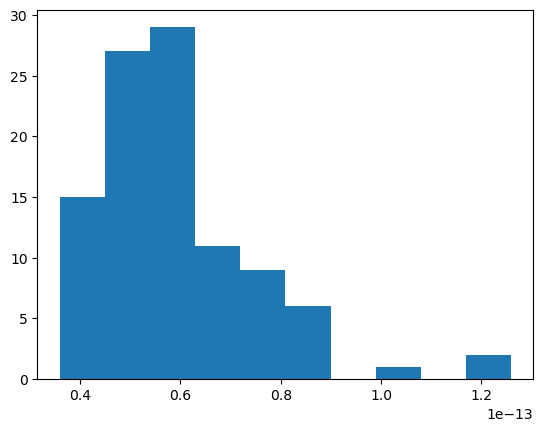

In [23]:
plt.hist(diff_error)

In [25]:
diff_error.max()

1.2586963630126082e-13

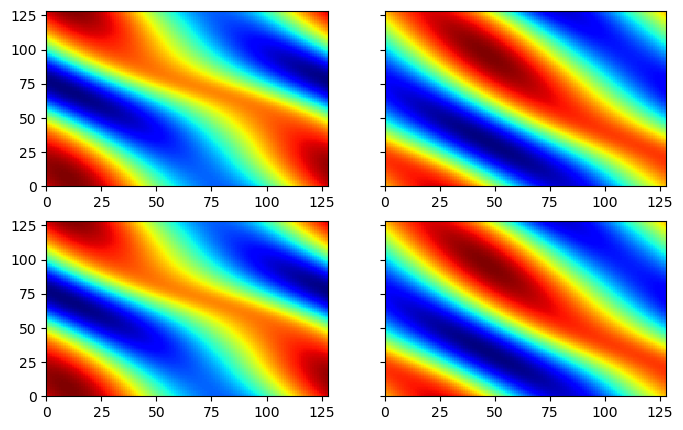

In [10]:
fig, axs = plt.subplots(2,2,figsize = (8,5), sharey=True)

i = -1

im1 = axs[0,0].pcolormesh(results1[i], cmap='jet')
#fig.colorbar(im1)

im2 = axs[0,1].pcolormesh(results2[i], cmap='jet')
#fig.colorbar(im2)

im3 = axs[1,0].pcolormesh(results1b[i].cpu().numpy(), cmap='jet')
#fig.colorbar(im3)

im4 = axs[1,1].pcolormesh(results2b[i].cpu().numpy(), cmap='jet')
#fig.colorbar(im4)

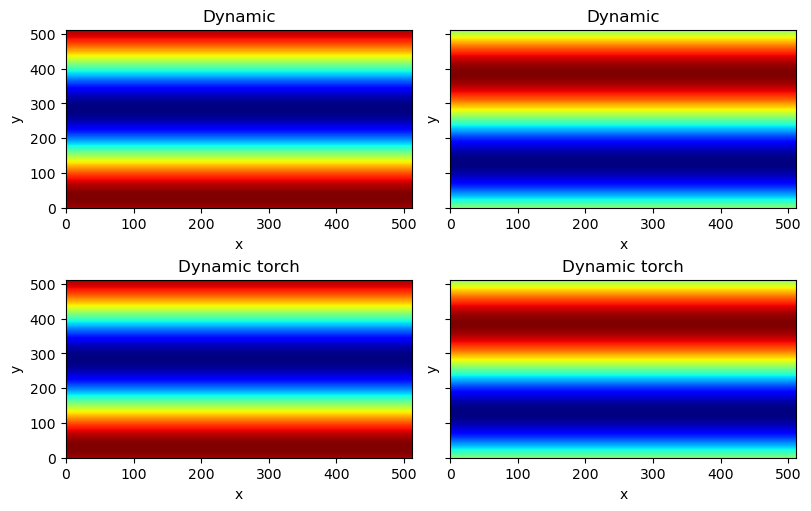

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results1[i]
    w02 = results2[i]
    w03 = results1b[i].cpu().numpy()
    w04 = results2b[i].cpu().numpy()

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0,0].pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0,0].set_title(r"Dynamic")
    axs[0,0].set_xlabel("x")
    axs[0,0].set_ylabel("y")

    # Plot the first subplot (Solution Visualization for u_0)
    im2 = axs[0,1].pcolormesh(w02, cmap='jet')
    #fig.colorbar(im1)
    axs[0,1].set_title(r"Dynamic")
    axs[0,1].set_xlabel("x")
    axs[0,1].set_ylabel("y")

    # Plot the first subplot (Solution Visualization for u_0)
    im3 = axs[1,0].pcolormesh(w03, cmap='jet')
    #fig.colorbar(im1)
    axs[1,0].set_title(r"Dynamic torch")
    axs[1,0].set_xlabel("x")
    axs[1,0].set_ylabel("y")

    # Plot the first subplot (Solution Visualization for u_0)
    im4 = axs[1,1].pcolormesh(w04, cmap='jet')
    #fig.colorbar(im1)
    axs[1,1].set_title(r"Dynamic torch")
    axs[1,1].set_xlabel("x")
    axs[1,1].set_ylabel("y")
    return im1, im2,im3, im4

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NVs_psm.gif", dpi=200, writer=PillowWriter(fps=50))

In [3]:
X = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 1  # Number of samples you want to generate
seed = 108  # Base seed for reproducibility
N_KL = 500

rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,n_samples))

def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=2.0, nu=1e-2, dt=5e-4,num_sol=100, method='CN',force = force_function)

In [4]:
sum_elements = [1,2,3,4,5,6,7,8,9,10,15,20,25,50,100,250,300,400]
length_scale = [np.sqrt(2), 7]
sample_list,solution_list = {}, {}

for ls in length_scale:
    sample_list[str(ls)] = []
    solution_list[str(ls)] = []

    for teta in sum_elements:
        theta_ = theta[:teta,:,:]
        omega0_ = omega0_samples(X, Y, theta_, d = 5,tau=ls)

        sample_list[str(ls)].append(omega0_[:,:,0])

        results = solver.run_simulation( np.array(omega0_[:,:,0]))

        solution_list[str(ls)].append(results[-1])

In [5]:
error_sample, error_sol = {},{}
for ls in length_scale:
    error_sample[str(ls)] = []
    error_sol[str(ls)] = []
    for i in range(1,len(sum_elements)):
        relterm = np.linalg.norm(sample_list[str(ls)][i],ord = 2)
        error_sample[str(ls)].append(np.linalg.norm(sample_list[str(ls)][i-1] - sample_list[str(ls)][i],ord=2)/relterm)
        relterm =  np.linalg.norm(solution_list[str(ls)][i],ord = 2)
        error_sol[str(ls)].append(np.linalg.norm(solution_list[str(ls)][i-1] - solution_list[str(ls)][i] ,ord=2)/ relterm)

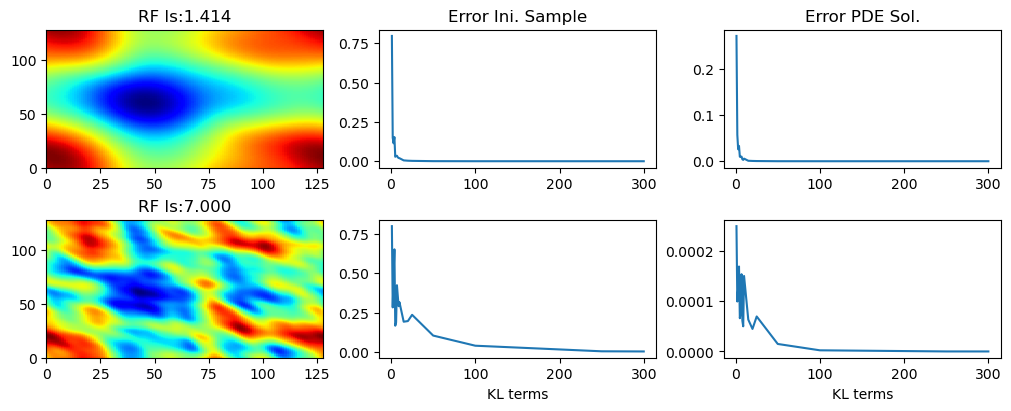

In [20]:
fig, axs = plt.subplots(2,3,figsize = (10,4), layout='constrained')

for i,ls in enumerate(length_scale):
    omega0_ = omega0_samples(X, Y, theta, d = 5,tau=ls)
    axs[i,0].pcolormesh(omega0_[:,:,0], cmap='jet')
    axs[i,1].plot(sum_elements[:-1],error_sample[str(ls)])
    axs[i,2].plot(sum_elements[:-1],error_sol[str(ls)])

    axs[i,0].set_title(f"RF ls:{ls:.3f}"), axs[0,1].set_title("Error Ini. Sample"), axs[0,2].set_title("Error PDE Sol.")
    axs[1,1].set_xlabel("KL terms"),axs[1,2].set_xlabel("KL terms")

# PSM comparison

In [6]:
data = jnp.load("./data//ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

solver = VorticitySolver2D(N=128, L=2*np.pi, T=10.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( np.array(w_ref[0,:,:]))

solver2 = torch_NVSolver2D(N=128, L=2*torch.pi, T=10.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN', device=device)

results2 = solver2.run_simulation(np.array(w_ref[0,:,:]))

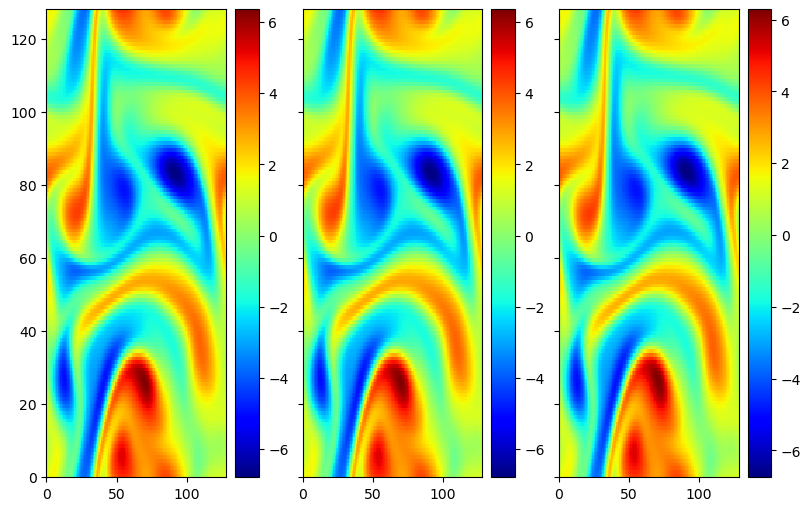

In [8]:
fig, axs = plt.subplots(1,3,figsize = (8,5), layout='constrained', sharey=True)

i = 50

im1 = axs[0].pcolormesh(results[i], cmap='jet')
fig.colorbar(im1)

im2 = axs[1].pcolormesh(results2[i].cpu().numpy(), cmap='jet')
fig.colorbar(im2)

im3 = axs[2].pcolormesh(w_ref[i,:,:], cmap='jet')
fig.colorbar(im3)

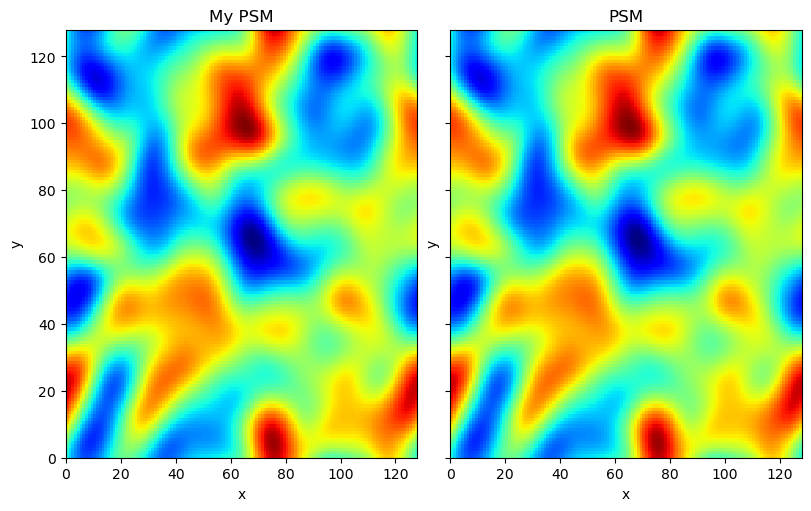

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results[i]
    w0b = results2[i].cpu().numpy()

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title(r"My PSM")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(w0b, cmap='jet')
    #fig.colorbar(im1)
    axs[1].set_title(r"My PSM torch")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    im3 = axs[2].pcolormesh(w_ref[i,:,:], cmap='jet')
    #fig.colorbar(im1)
    axs[1].set_title(r"PSM")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    return im1,im2,im3

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=200)    
ani.save("./results/NVs_comparison.gif", dpi=200, writer=PillowWriter(fps=50))

## PSM with Force

In [27]:
def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w_ref[0,:,:]))

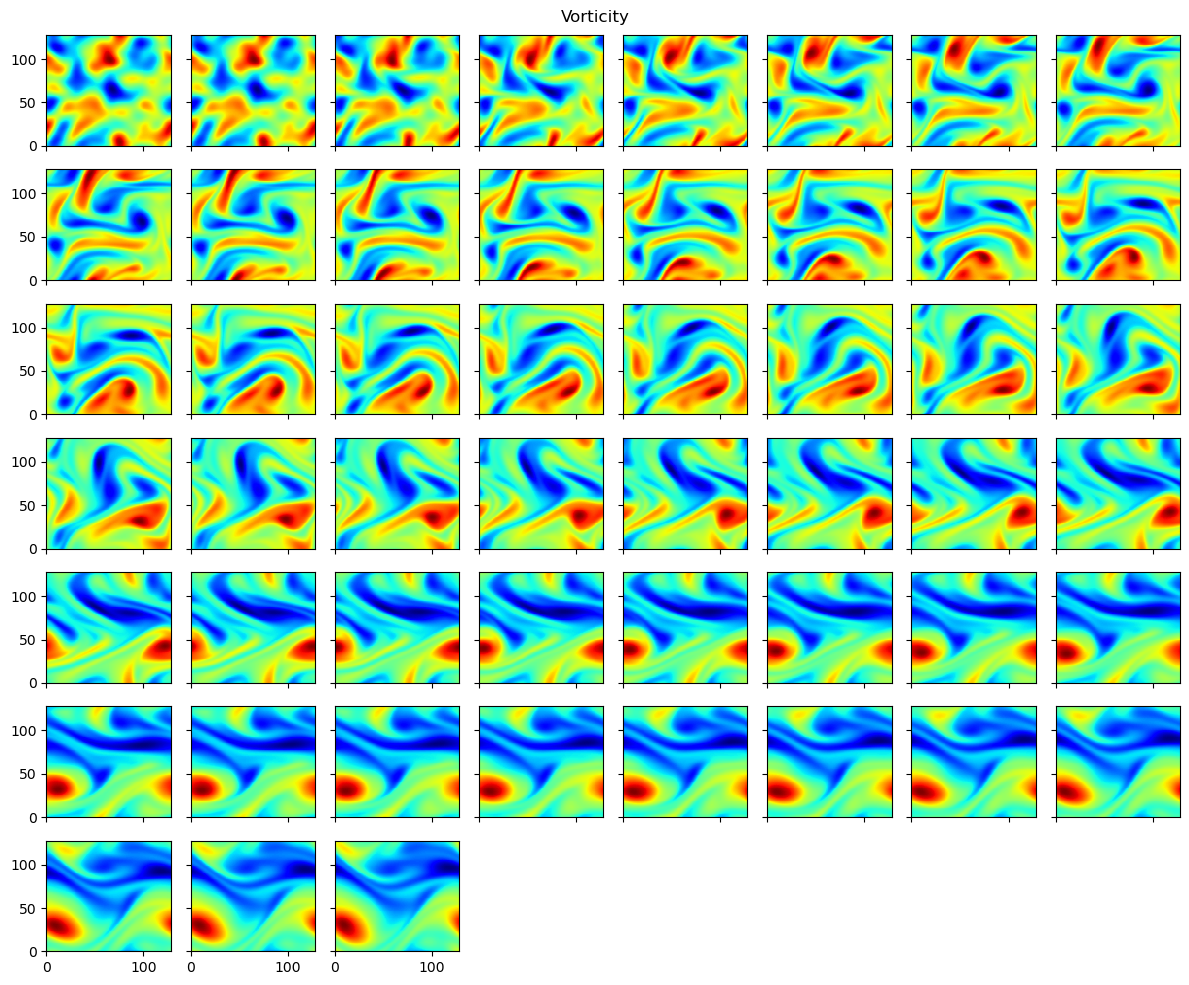

In [9]:
num_plots = len(results)
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create a figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 10),sharex = True, sharey = True)
fig.suptitle("Vorticity")

# Flatten axes array for easy iteration if there's more than 1 row
axs = axs.flatten() if num_plots > 1 else [axs]

# Loop through each vorticity field in w_list and plot it
for i,j in enumerate(range(0,num_plots)):
    im = axs[i].pcolormesh(results[j], cmap="jet")
    #axs[i].set_title(f"Step {i*100}")
    #fig.colorbar(im, ax=axs[i])

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

In [9]:
import h5py

with h5py.File('./data/ns_V1e-3_N5000_T50.mat', 'r') as f:
    # Print the keys of the file
    print(f.keys())
    a = f["a"][:]
    t = f["t"][:]
    u = f["u"][:]



<KeysViewHDF5 ['a', 't', 'u']>


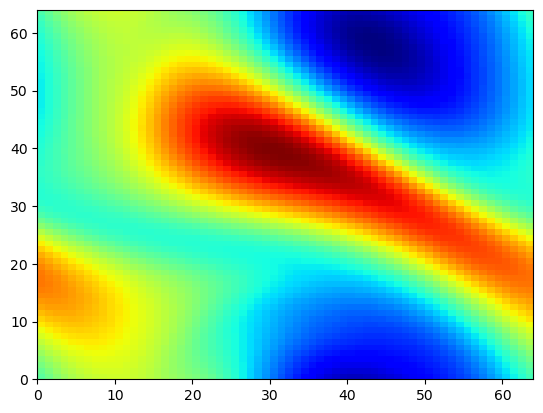

In [14]:
plt.pcolormesh(u[-1,:,:,1], cmap="jet")


In [11]:
def force_function(X, Y):
    return 0.1 * (torch.sin(2*torch.pi*(X + Y)) + torch.cos(2*torch.pi*(X + Y)))

solver2 = torch_NVSolver2D(N=64, L=1, T=50.0, nu=1e-3, dt=1e-4,num_sol=200, method='CN', device=device,force=force_function)

results2 = solver2.run_simulation(np.array(u[0,:,:,1]))

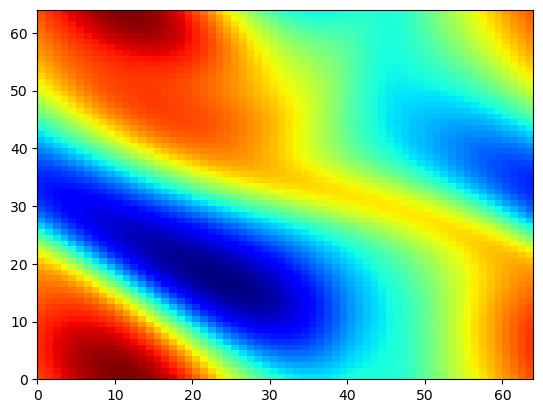

In [30]:

plt.pcolormesh(results2[110].cpu().numpy(), cmap="jet")


# Convergence

In [29]:
seed = 108
N = 128
N_KL = 50
T = 1
dt = 5e-4
nu = 1e-2

xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

#FEM
def force_function_FEM(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=N_KL, dt=dt,T=T,nu=nu,force_func=force_function_FEM, d= 5, tau =10,seed = 108)

fem_solver.run()

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_final = fem_solver.evaluate_at_points(points)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),(X, Y), method='cubic')

z_final = griddata((X.reshape(-1), Y.reshape(-1)), u_final.flatten(),(X, Y), method='cubic')

In [63]:
# PSM
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=T, nu=nu, dt=dt,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w0[:,:,0]))

Text(0.5, 0, 'x')

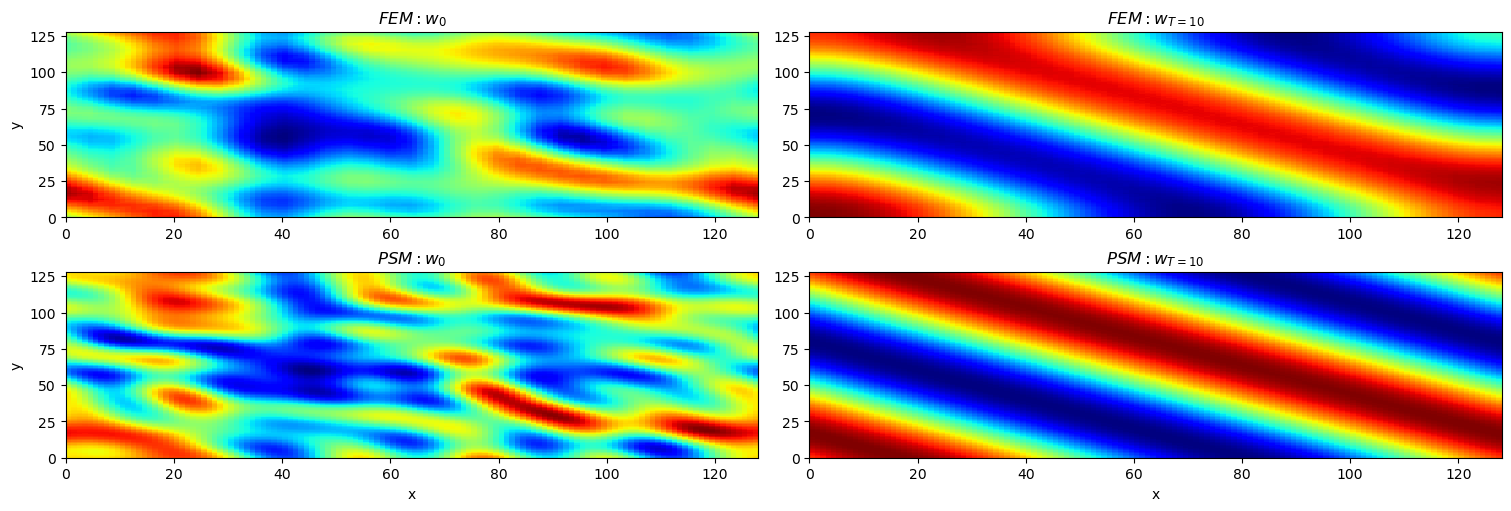

In [33]:
fig, axs = plt.subplots(2,2,figsize = (15,5), layout='constrained')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0,0].pcolormesh(z_0, cmap='jet')
axs[0,0].set_title(r"$FEM: w_{0}$")
axs[0,0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[0,1].pcolormesh(z_final, cmap='jet')
axs[0,1].set_title(r"$FEM: w_{T=10}$")

cp0 = axs[1,0].pcolormesh(results[0], cmap='jet')
axs[1,0].set_title(r"$PSM: w_{0}$")
axs[1,0].set_ylabel("y")
axs[1,0].set_xlabel("x")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1,1].pcolormesh(results[-1], cmap='jet')
axs[1,1].set_title(r"$PSM: w_{T=10}$")
axs[1,1].set_xlabel("x")

In [ ]:

# Function to interpolate a solution to a new grid
def interpolate_to_grid(solution, old_x, old_y, new_x, new_y):
    interpolator = interp2d(old_x, old_y, solution, kind='cubic')  # Use cubic interpolation
    return interpolator(new_x, new_y)

# Run simulations for increasing spatial resolutions
N_values = [64, 128, 256, 512,1024]

nu = 1e-2
solutions = {"NoF":[],"F":[]}
for N in N_values:

    old_x = np.linspace(0, 2 * np.pi, 128, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, 128, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    
    interpolated_solution = interpolate_to_grid(np.array(w_ref[0,:,:]), old_x, old_y, new_x, new_y)

    X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
    w0 = omega0_samples(X, Y, theta, d = 5,tau=10)
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( interpolated_solution)
    solutions["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN')
    results = solver.run_simulation( interpolated_solution)
    solutions["NoF"].append(results[-1])

In [31]:
# Initialize error dict
errors = {"NoF":[],"F":[]}

# Loop to compare successive resolutions
for i in range(1, len(N_values)):
        # Define the grids for the current and previous resolutions
    N_old = N_values[i-1]
    N_new = N_values[-1]
    
    old_x = np.linspace(0, 2 * np.pi, N_old, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, N_old, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 

    for typ in errors.keys():
        # Interpolate the lower-resolution solution to the higher-resolution grid
        interpolated_solution = interpolate_to_grid(solutions[typ][i-1], old_x, old_y, new_x, new_y)

        # Compute relative error norm
        error = np.linalg.norm(solutions[typ][-1] - interpolated_solution) / np.linalg.norm(solutions[typ][-1])
        errors[typ].append(error)

In [30]:
# Run simulations for decreasing time steps
N = 128
dt_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solutions_dt = {"NoF":[],"F":[]}
for dt in dt_values:
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=50, method='CN')
    results = solver.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["NoF"].append(results[-1])

In [35]:
# Compute errors between successive time steps
errors_dt = {"NoF":[],"F":[]}

for i in range( len(dt_values)-1):
    for typ in errors_dt.keys():
        error_dt = np.linalg.norm(solutions_dt[typ][i] - solutions_dt[typ][-1]) / np.linalg.norm(solutions_dt[typ][-1])
        errors_dt[typ].append(error_dt)

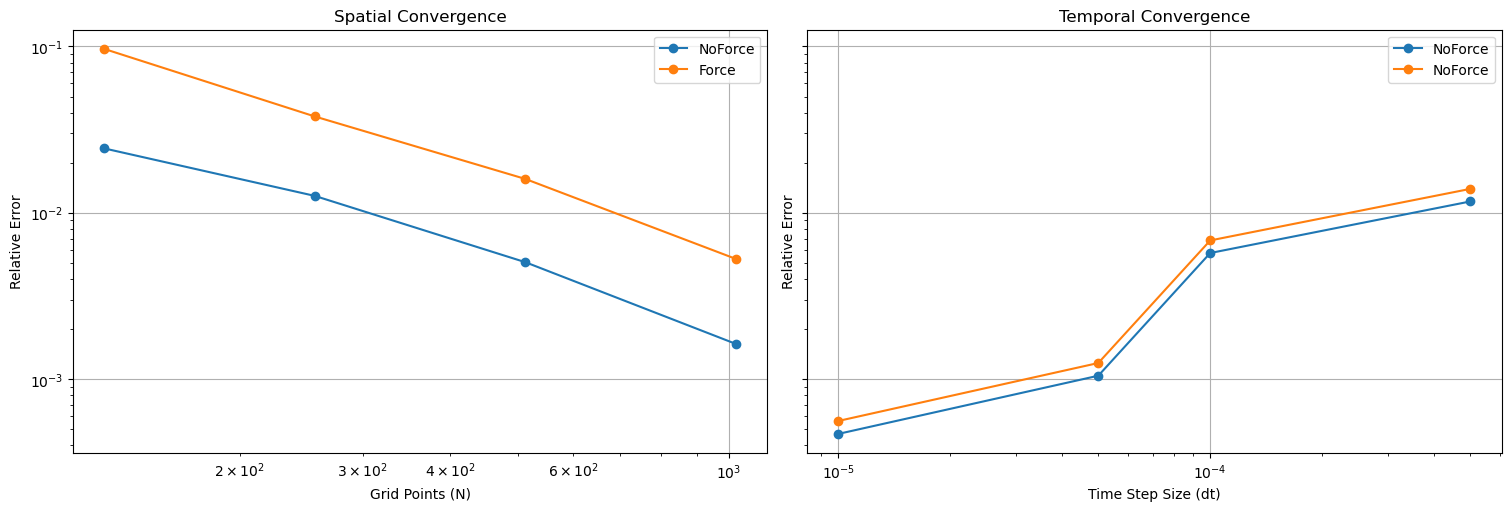

In [44]:
fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained',sharey=True)

# Plot the first subplot (Solution Visualization for u_0)
axs[0].loglog(N_values[1:], errors["NoF"], '-o', label="NoForce")
axs[0].loglog(N_values[1:], errors["F"], '-o', label="Force")
axs[0].set_title(r"Spatial Convergence")
axs[0].set_xlabel("Grid Points (N)")
axs[0].set_ylabel("Relative Error")
axs[0].legend()
axs[0].grid()

axs[1].loglog(dt_values[1:], errors_dt["NoF"], '-o', label="NoForce")
axs[1].loglog(dt_values[1:], errors_dt["F"], '-o', label="NoForce")
axs[1].set_title(r"Temporal Convergence")
axs[1].set_xlabel("Time Step Size (dt)")
axs[1].set_ylabel("Relative Error")
axs[1].legend()
axs[1].grid()